# Fake News Exploratory Data Analysis

Get subset of FakeNewCorpus data set.

In [3]:
import pandas as pd
import regex as re
from cleantext import clean
raw_data = pd.read_csv('https://raw.githubusercontent.com/several27/FakeNewsCorpus/master/news_sample.csv', dtype={"content": "string"})
raw_data.head()

,Unnamed: 0,id,domain,type,url,content,scraped_at,inserted_at,updated_at,title,authors,keywords,meta_keywords,meta_description,tags,summary
0,0,141,awm.com,unreliable,http://awm.com/church-congregation-brings-gift...,Sometimes the power of Christmas will make you...,2018-01-25 16:17:44.789555,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,Church Congregation Brings Gift to Waitresses ...,Ruth Harris,NaN,[''],NaN,NaN,NaN
1,1,256,beforeitsnews.com,fake,http://beforeitsnews.com/awakening-start-here/...,AWAKENING OF 12 STRANDS of DNA – “Reconnecting...,2018-01-25 16:17:44.789555,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,AWAKENING OF 12 STRANDS of DNA – “Reconnecting...,Zurich Times,NaN,[''],NaN,NaN,NaN
2,2,700,cnnnext.com,unreliable,http://www.cnnnext.com/video/18526/never-hike-...,Never Hike Alone: A Friday the 13th Fan Film U...,2018-01-25 16:17:44.789555,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,Never Hike Alone - A Friday the 13th Fan Film ...,NaN,NaN,[''],Never Hike Alone: A Friday the 13th Fan Film ...,NaN,NaN
3,3,768,awm.com,unreliable,http://awm.com/elusive-alien-of-the-sea-caught...,"When a rare shark was caught, scientists were ...",2018-01-25 16:17:44.789555,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,Elusive ‘Alien Of The Sea ‘ Caught By Scientis...,Alexander Smith,NaN,[''],NaN,NaN,NaN
4,4,791,bipartisanreport.com,clickbait,http://bipartisanreport.com/2018/01/21/trumps-...,Donald Trump has the unnerving ability to abil...,2018-01-25 16:17:44.789555,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,Trump’s Genius Poll Is Complete & The Results ...,Gloria Christie,NaN,[''],NaN,NaN,NaN


### Cleaning and preprocessing

In [ ]:
import pandas as pd
import regex as re
from cleantext import clean
import pyarrow.feather as feather
from multiprocessing import Pool
import gc
import nltk
import itertools
import numpy as np
from nltk.corpus import stopwords
from nltk.stem.porter import *
import time

Perform basic cleaning: remove urls, dates, numbers, emails.

In [10]:
data = raw_data.copy(deep = True)

In [5]:
mail_pattern = re.compile(r"(?P<Mails>[\w\.-]+@[\w\.-]+\.[\w]+)")
url_pattern = re.compile(r"(?P<URL>(?:(?:https?|ftp):[/][/])?[\w/\-?=%.]+\.[\w/\-&?=%.]+)")
date_pattern = re.compile(r"([\d]{1,2}[\/|\-][\d]{1,2}(?:[\/|\-][\d]{2,4})?|[\d]{2,4}[\/|\-][\d]{1,2}[\/|\-][\d]{1,2}|(?:january|february|march|april|may|june|july|august|september|october|november|december)[\s][\d]{1,2}[a-z][a-z](?:\s[\d]{2,4})|[\d][\d]\w?\w?\sof\s(?:january|february|march|april|may|june|july|august|september|october|november|december)(?:\s[\d]{2,4})?|(?:january|february|march|april|may|june|july|august|september|october|november|december)\s\d\d?\w?\w?,?(?:\s\d{2,4})?)")
num_pattern = re.compile(r"\w*\d+\w*")
punct_remove = re.compile(r"[^\w\s]+")
white_space = re.compile(r"[\s]+|\n+")

def clean_string(st):
    s1 = st.lower()
    s2 = mail_pattern.sub("mail", s1)
    s3 = url_pattern.sub("url", s2)
    s4 = date_pattern.sub("date", s3)
    s5 = num_pattern.sub("num", s4)
    s6 = punct_remove.sub(" ", s5)
    s7 = white_space.sub(" ", s6)
    return s7

def clean_dataframe(dataframe):
    start = time.time()
    dataframe['content'] = dataframe['content'].apply(clean_string)
    end = time.time()
    print("cleaning took " + str(end - start) + " seconds")

In [11]:
clean_dataframe(data)
data['content'].head()

0    sometimes the power of christmas will make you...
1    awakening of num strands of dna - "reconnectin...
2    never hike alone: a friday the 13th fan film u...
3    when a rare shark was caught, scientists were ...
4    donald trump has the unnerving ability to abil...
Name: content, dtype: object

Tokenize the text
Remove stopwords and compute reduction of vocabulary rate after having removed them
Stem words and compute reduction rate of vocabulary

In [12]:
def remove_english_stopwords(stopwords):
    def remove_stopwords(tokenlist):
        return filter(lambda x : x not in stopwords, tokenlist)
    return remove_stopwords

def stem_tokens():
    stemmer = PorterStemmer()
    def stem_tokenlist(tokenlist):
        return map(stemmer.stem, tokenlist)
    return stem_tokenlist

def tokenize():
    def tokenize_text(s):
        return list((map(nltk.word_tokenize, s)))
    return tokenize_text

def to_list():
    def turn_to_list(it):
        return list(it)
    return turn_to_list

def preprocess(dataframe):
    
    # Failsafe. Raises an error in case we are running twice // try to feed it with the tokenized string rather than a list.
    try:
        assert isinstance(dataframe['content'][0], str)
    except AssertionError:
        raise ValueError("Input should be a string")


    # tokenize content column
    #print("Tokenizing...")
    start = time.time()
    dataframe['content'] = dataframe['content'].apply(nltk.word_tokenize)
    end = time.time()
    print("tokenizing took " + str(end - start) + " seconds")
    #tokens = list(itertools.chain.from_iterable(dataframe['content']))
    #vocabulary = set(tokens)
    # remove stopwords
    start = time.time()
    dataframe['content'] = dataframe['content'].apply(remove_english_stopwords(stopwords.words('english')))
    end = time.time()
    print("removing stopwords took " + str(end - start) + " seconds")
    #tokens_no_stopwords = list(itertools.chain.from_iterable(dataframe['content']))
    #vocabulary_no_stopwords = set(tokens_no_stopwords)
    #print("Reduction rate of removing stopwords: " + str(1 - len(vocabulary_no_stopwords) / len(vocabulary)))
    # stem tokens
    start = time.time()
    dataframe['content'] = dataframe['content'].apply(stem_tokens())
    end = time.time()
    print("stemming took " + str(end - start) + " seconds")

    start = time.time()
    dataframe['content'] = dataframe['content'].apply(to_list())
    end = time.time()
    print("converting to list took" + str(end - start) + " seconds")

    #tokens_stem = list(itertools.chain.from_iterable(dataframe['content']))
    #print("Stemmed tokens = " + str(tokens_stem))
    #vocabulary_stem = set(tokens_stem)
    #print("Reduction rate of stemming: " + str(1 - len(vocabulary_stem)/len(vocabulary_no_stopwords)))

In [13]:
preprocess(data)
data['content']

Tokenizing...
Removing stopwords...
Reduction rate of removing stopwords: 0.007993701931811259
Stemming...
Reduction rate of stemming: 0.32144371101556346


0      [sometim, power, christma, make, wild, wonder,...
1      [awaken, num, strand, dna, -, ``, reconnect, '...
2      [never, hike, alon, :, friday, 13th, fan, film...
3      [rare, shark, caught, ,, scientist, left, blun...
4      [donald, trump, unnerv, abil, abil, creat, rea...
                             ...                        
245    [prison, rahm, ,, god, 's, work, mani, other, ...
246    [num, use, item, tini, home, headlin, :, bitco...
247    [former, cia, director, michael, hayden, said,...
248    [antonio, sabato, jr., say, hollywood, 's, lib...
249    [former, u.s., presid, bill, clinton, monday, ...
Name: content, Length: 250, dtype: object

Next, we define functions that can visualize our dataset

### Visualization of data set

In [89]:
import numpy as np
import matplotlib.pyplot as plt

In [90]:
def pair_keyword_type(keyword): 
    dataarray = []
    for i in range(0,data.__len__()): 
        instances = data.content[i].count(str(keyword))
        dataarray.append((instances,data.type[i]))
    return dataarray

In [91]:
def scatterplot_keyword_type(keyword):
    pair_keyword_list = pair_keyword_type(keyword)
    tuple_array = pair_keyword_type(keyword)
    typearray = []
    countarray = []
    for i in range(0,pair_keyword_list.__len__()): 
        typearray.append(str(tuple_array[i][1]))
        countarray.append(tuple_array[i][0])
    fig = plt.figure()
    ax =fig.add_axes([0,0,2,1])
    ax.scatter(typearray,countarray)
    plt.xticks(rotation = 'vertical')
    plt.show()

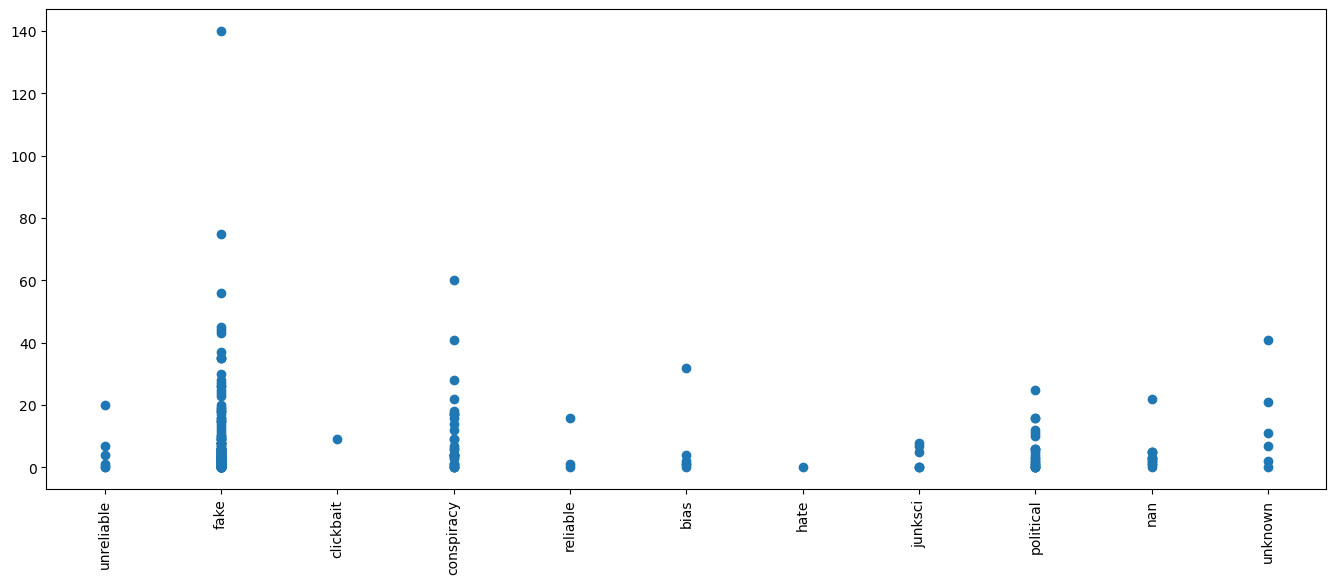

In [92]:
scatterplot_keyword_type('num')

In [93]:
def boxplot_keyword_type(keyword):
    tuple_array=pair_keyword_type(keyword) 
    boxdata=[]
    dict = {}
    for i in range(0,len(tuple_array)):
        if tuple_array[i][1] not in dict:
            dict[tuple_array[i][1]] = [tuple_array[i][0]]
        else:
            dict[tuple_array[i][1]].append(tuple_array[i][0])
    for i in dict:
        boxdata.append(dict[i])
    fig = plt.figure()
    ax =fig.add_axes([0,0,2,1])
    ax.boxplot(boxdata, labels = list(dict.keys()))
    plt.xticks(rotation = 'vertical')
    plt.show()

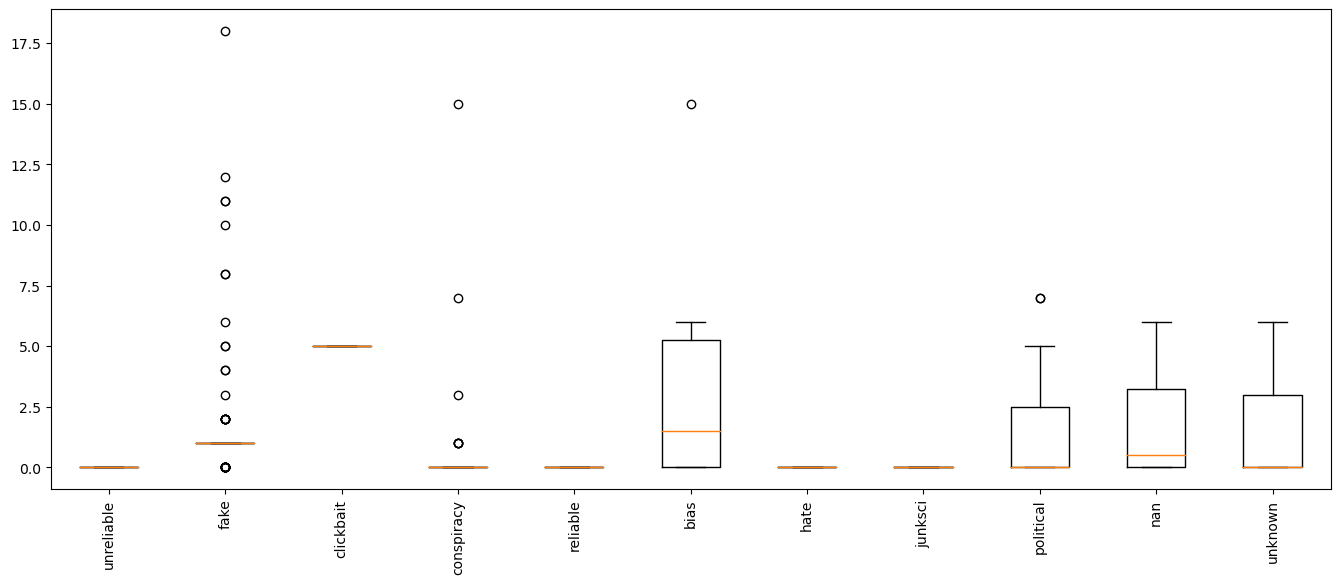

In [94]:
boxplot_keyword_type('trump')

In [95]:
def barplot_keyword_type(keyword): 
    tuple_array = pair_keyword_type(keyword)
    rawdict = {}
    for i in range(0,len(tuple_array)):
        if tuple_array[i][1] not in rawdict:
            rawdict[tuple_array[i][1]] = [tuple_array[i][0]]
        else:
            rawdict[tuple_array[i][1]].append(tuple_array[i][0])

    meandict={}
    for i in rawdict: 
        meandict[i] = np.mean(rawdict[i])
    mediandict={}
    for i in rawdict: 
        mediandict[i] = np.median(rawdict[i])
    meanvals =[]
    medianvals=[]
    for i in mediandict:
        medianvals.append(mediandict[i])
    for i in meandict:
        meanvals.append(meandict[i])
    types = list(mediandict.keys())
    types = [str(i) for i in types]
    print(medianvals)
    print(meanvals)
    print(types)
    df = pd.DataFrame({
    'types': types,
    'meanvals': meanvals,
    'medianvals': medianvals
    })
    df.plot(x="types", y=["meanvals", "medianvals"], kind="bar", figsize=(10,5))
    

[2.5, 3.0, 9.0, 6.0, 1.0, 1.5, 0.0, 2.5, 3.0, 3.0, 9.0]
[5.333333333333333, 8.651612903225807, 9.0, 10.709677419354838, 5.666666666666667, 6.666666666666667, 0.0, 3.3333333333333335, 5.6521739130434785, 4.333333333333333, 13.666666666666666]
['unreliable', 'fake', 'clickbait', 'conspiracy', 'reliable', 'bias', 'hate', 'junksci', 'political', 'nan', 'unknown']


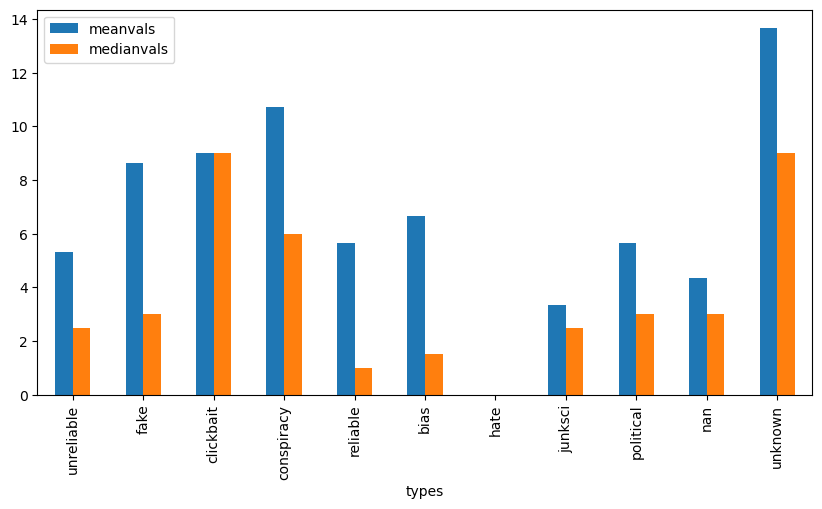

In [96]:
barplot_keyword_type('num') 

### Get subset of full dataset

First we import the necessary libraries

In [4]:
import csv
import pandas as pd
import random
import pyarrow.feather as feather
import regex as re
from cleantext import clean
import pyarrow.feather as feather
from multiprocessing import Pool
import gc
import nltk
import itertools
import numpy as np
from nltk.corpus import stopwords
from nltk.stem.porter import *
import time

We load the full data set

In [3]:
full_data = pd.read_csv("data/news_cleaned_2018_02_13-1.csv", on_bad_lines='skip')

/var/folders/gj/r8x5s5mn7jg12hs3c28wpg4c0000gn/T/ipykernel_1600/3260015146.py:1: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  full_data = pd.read_csv("data/news_cleaned_2018_02_13-1.csv", on_bad_lines='skip')


In [4]:
len(full_data)

11558723

We get a sample consisting of 10% of the full dataset

In [5]:
full_data_sample = full_data.sample(frac=0.1, random_state=1)

In [6]:
full_data_sample.head()

,Unnamed: 0,id,domain,type,url,content,scraped_at,inserted_at,updated_at,title,authors,keywords,meta_keywords,meta_description,tags,summary,source
11467794,8027,9787368,nytimes.com,reliable,https://query.nytimes.com/gst/fullpage.html?re...,"KASHA--Audrey Sission, a lifelong New Yorker, ...",2018-02-11 00:48:58.787555,2018-02-11 00:14:20.346838,2018-02-11 00:14:20.346871,"Paid Notice: Deaths KASHA, AUDREY SISSION",NaN,NaN,['KASHA AUDREY SISSION'],"KASHA--Audrey Sission, a lifelong New Yorker, ...",NaN,NaN,nytimes
4591569,8760,3009581,thinkprogress.org,political,https://thinkprogress.org/into-the-valley-of-d...,"“Forward, the Light Brigade!”Was there a man d...",2017-11-18T20:01:27.400599,2018-02-07 23:39:33.852671,2018-02-07 23:39:33.852696,"Into The Valley Of Death Rode The 600, Into Th...",NaN,NaN,[''],NaN,"#Climate Change, #Climate",NaN,NaN
6162754,2521,4251195,truthandaction.org,bias,http://www.truthandaction.org/woman-thrown-off...,Woman Thrown Off Plane When She Said Hillary i...,2017-11-27T01:15:32.269834,2018-02-07 23:39:33.852671,2018-02-07 23:39:33.852696,Woman Thrown Off Plane When She Said Hillary i...,NaN,NaN,[''],NaN,NaN,NaN,NaN
4250359,effort to turn this election into a referendu...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4742331,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
len(full_data_sample)

1155872

Next, we make sure to delete the full data set from memory such that we can save our sample

In [8]:
import gc

In [9]:
del full_data
gc.collect()

15

Then, we save the sample to csv format

In [48]:
full_data_sample.to_csv("data/sample.csv")

We see that there is a lot of rows where the "content" tab is null, so we delete those

CODE HERRE TO SHOW THE ABOVE

In [12]:
full_data_sample_clean_content = full_data_sample.drop(full_data_sample[full_data_sample.content.isnull()].index)

In [15]:
print("Removed " + str(len(full_data_sample) - len(full_data_sample_clean_content)) + " rows")

Removed 210005 rows


In [20]:
len(full_data_sample_clean_content)

929381

In order to save to a binary format like feather we first need to make sure that each row has the same data types in each column

In [18]:
full_data_sample_clean_content = full_data_sample_clean_content[pd.to_numeric(full_data_sample_clean_content['Unnamed: 0'], errors='coerce').notnull()]

In [39]:
full_data_sample_clean_content['Unnamed: 0'] = full_data_sample_clean_content['Unnamed: 0'].astype('int64')

/var/folders/gj/r8x5s5mn7jg12hs3c28wpg4c0000gn/T/ipykernel_1600/3315519236.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_data_sample_clean_content['Unnamed: 0'] = full_data_sample_clean_content['Unnamed: 0'].astype('int64')


In [40]:
full_data_sample_clean_content['id'] = full_data_sample_clean_content['id'].astype('int64')

/var/folders/gj/r8x5s5mn7jg12hs3c28wpg4c0000gn/T/ipykernel_1600/3811944661.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_data_sample_clean_content['id'] = full_data_sample_clean_content['id'].astype('int64')


In [42]:
full_data_sample_clean_content.dtypes

Unnamed: 0           int64
id                   int64
domain              object
type                object
url                 object
content             object
scraped_at          object
inserted_at         object
updated_at          object
title               object
authors             object
keywords            object
meta_keywords       object
meta_description    object
tags                object
summary             object
source              object
dtype: object

Then, we write the sample to binary format for faster loading times

In [46]:
import pyarrow.parquet as pq
import pyarrow as pa

In [ ]:
full_data_sample_clean_content.to_csv("data/sample_STRUCTURED.csv")

In [51]:
##pq.write_table(full_data_sample_clean_content, "data/sample_STRUCTURED.parquet")

In [ ]:
#sample_parquet = pa.Table.from_pandas("data/sample_STRUCTURED.parquet")

In [ ]:
#sample_parquet.to_csv("data/sample_STRUCTURED.csv")

### Preprocessing the larger sample

Then, we preprocess the larger sample

In [ ]:
file_name = "data/sample_preprocessed.csv"
with open(file_name, "w") as file:
    pass

In [1]:
for chunck in pd.read_csv("data/sample_STRUCTURED.csv", chunksize=10000):
    clean_dataframe(chunck)
    preprocess(chunck)
    start = time.time()
    chunck.to_csv(file_name, mode='a')
    end = time.time()
    print("writing to csv took " + str(end - start) + " seconds")

NameError: name 'pd' is not defined

### Inspecting the sample

In [5]:
data = pd.read_csv("sample_preprocessed_no_punct.csv")

In [8]:
typedict = {}
for i in data['type']: 
    if str(i) in typedict:
        typedict[str(i)] +=1 
    else: 
        typedict[str(i)] =1 
typedict
typedictperc = typedict.copy()
#laver et nyt dictionairy som viser det i procenttal
for i in typedictperc:
    typedictperc[i] = (typedictperc[i]/(len(data)))*100

typedictperc

{'reliable': 20.5789732461298,
 'political': 26.080370274338254,
 'bias': 12.250382743769856,
 'nan': 4.345365599646251,
 'satire': 1.1984210407402904,
 'fake': 9.648800987226094,
 'conspiracy': 8.92591823538715,
 'unknown': 3.9764468682791216,
 'rumor': 5.189069504977552,
 'unreliable': 3.2139717883144536,
 'clickbait': 2.487646225334141,
 'junksci': 1.2684607298974795,
 'hate': 0.8262746739281293,
 'type': 0.009898082031430715}

In [1]:
allArticlesCount = 928083 + 146080 + 1300444 + 905981 + 144939 + 117374 + 292201 + 2435471 + 319830 + 1920139
#Jeg henter data from README.md om hvor mange artikler af hver type, der er i det fulde datasæt
realtypeperc = {"reliable": (1920139/allArticlesCount)*100, "political": (2435471/allArticlesCount)*100, "bias": (1300444/allArticlesCount)*100, "Satire": (146080/allArticlesCount)*100, "fake": (928083/allArticlesCount)*100, "conspiracy":(905981/allArticlesCount)*100, "unreliable": (319830/allArticlesCount)*100, "clickbait":(292201/allArticlesCount)*100, "junksci":(144939/allArticlesCount)*100 , "hate":(117374/allArticlesCount)*100}
realtypeperc
#jeg præsenterer det som procenter
#ved sammenligning er det tydeligt, at Mikkels forkortede datasæt ikke har markant anderledes proportion ift. artikeltyper, end det fulde datasæt
#Største forskel er at der er tilføjet nye typer af artikler som rumor til datasættet, siden README blev skrevet. 
#Vi kan bruge dette til at forsikre os selv om at vores forkortede datasæt er repræsentativt for det fulde datasæt. 

{'reliable': 22.561888537768805,
 'political': 28.617108052577617,
 'bias': 15.280389897611691,
 'Satire': 1.716459421738357,
 'fake': 10.905098641191126,
 'conspiracy': 10.645397202669349,
 'unreliable': 3.7580450222794273,
 'clickbait': 3.4334005989277774,
 'junksci': 1.703052520039264,
 'hate': 1.3791601051965903}